In [1]:
!pip install transformers torchvision lpips

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 33.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 46.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 27.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 18.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 73.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 5.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling

Imports

In [2]:
import torch
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image
import requests
from transformers import CLIPProcessor, CLIPModel
import lpips

device = "cuda" if torch.cuda.is_available() else "cpu"


Load in Style image

In [6]:
import os
from google.colab import files

os.makedirs("data", exist_ok=True)

uploaded = files.upload()

# Move uploaded images into the data/ folder
for fname in uploaded:
    with open(os.path.join("data", fname), "wb") as f:
        f.write(uploaded[fname])

Saving starry_night.png to starry_night.png


Pre-process image data

In [7]:
from PIL import Image
from torchvision import transforms
import torch

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

def load_images_from_folder(folder_path):
    image_tensors, image_pils, filenames = [], [], []

    for filename in sorted(os.listdir(folder_path)):
        if filename.lower().endswith((".png", ".jpg", ".jpeg")):
            path = os.path.join(folder_path, filename)
            pil_img = Image.open(path).convert("RGB")
            image_tensor = transform(pil_img).unsqueeze(0)
            image_tensors.append(image_tensor)
            image_pils.append(pil_img)
            filenames.append(filename)

    return image_pils, torch.cat(image_tensors), filenames

pil_imgs, img_tensors, filenames = load_images_from_folder("data")
device = "cuda" if torch.cuda.is_available() else "cpu"

Load in CLIPS / LPIPS models

In [8]:
from transformers import CLIPProcessor, CLIPModel
import lpips

clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
lpips_model = lpips.LPIPS(net='alex').to(device)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 169MB/s]


Loading model from: /usr/local/lib/python3.11/dist-packages/lpips/weights/v0.1/alex.pth


Create trainable perturbations

In [12]:
def cloak_image(style_tensor, n_steps=200, alpha=1.0, beta=0.5):
    delta = torch.zeros_like(style_tensor, requires_grad=True)
    optimizer = torch.optim.Adam([delta], lr=1e-1)

    for step in range(n_steps):
        optimizer.zero_grad()
        perturbed = torch.clamp(style_tensor + delta, 0, 1)

        # CLIP embeddings
        inputs = clip_processor(images=[style_tensor.squeeze(0), perturbed.squeeze(0)], return_tensors="pt").to(device)
        outputs = clip_model.get_image_features(**inputs)
        orig_embed, pert_embed = outputs[0], outputs[1]

        #clip_dist = 1 - torch.nn.functional.cosine_similarity(orig_embed, pert_embed)
        clip_dist = 1 - torch.nn.functional.cosine_similarity(orig_embed, pert_embed, dim=-1).mean()

        lpips_loss = lpips_model(style_tensor, perturbed)

        loss = alpha * clip_dist + beta * lpips_loss
        loss.backward()
        optimizer.step()

    final_perturbed = torch.clamp(style_tensor + delta, 0, 1)
    return final_perturbed.detach()


In [13]:
from torchvision.transforms.functional import to_pil_image

os.makedirs("results/cloaked", exist_ok=True)
os.makedirs("results/original", exist_ok=True)

cloaked_imgs = []

for i, fname in enumerate(filenames):
    print(f"Processing: {fname}")
    orig = img_tensors[i:i+1].to(device)
    cloaked = cloak_image(orig)

    # Save
    to_pil_image(orig.squeeze().cpu()).save(f"results/original/{fname}")
    to_pil_image(cloaked.squeeze().cpu()).save(f"results/cloaked/{fname}")
    cloaked_imgs.append(cloaked.cpu())


Processing: starry_night.png


option 2: randomly just set pixels to be white

In [22]:
import torch

def random_pixel_mask(style_tensor, mask_ratio=0.1, mode="black"):
    """
    Randomly masks pixels in the image tensor.
    Args:
        style_tensor: image tensor of shape [1, 3, H, W]
        mask_ratio: proportion of pixels to replace
        mode: "black" or "white" (pixel replacement value)
    Returns:
        perturbed_tensor: same shape as input
    """
    assert mode in ["black", "white"], "Mode must be 'black' or 'white'"

    c, h, w = style_tensor.shape[1:]  # [1, 3, H, W]
    total_pixels = h * w
    num_to_mask = int(mask_ratio * total_pixels)

    # Generate random coordinates
    mask_indices = torch.randperm(total_pixels)[:num_to_mask]
    y_coords = mask_indices // w
    x_coords = mask_indices % w

    perturbed = style_tensor.clone()

    # Replace pixel values at random coords
    value = 0.0 if mode == "black" else 1.0
    for i in range(num_to_mask):
        perturbed[0, :, y_coords[i], x_coords[i]] = value

    return torch.clamp(perturbed, 0, 1)

In [36]:
os.makedirs("results/random_masked", exist_ok=True)

masked_imgs = []

for i, fname in enumerate(filenames):
    print(f"Random masking: {fname}")
    orig = img_tensors[i:i+1].to(device)
    masked = random_pixel_mask(orig, mask_ratio=1, mode="black")  # Try 10% masking

    # Save
    to_pil_image(torch.clamp(masked.squeeze().cpu(), 0, 1)).save(f"results/random_masked/{fname}")
    masked_imgs.append(masked.cpu())


Random masking: starry_night.png


In [37]:
embedding_diffs_masked = []

for i in range(len(filenames)):
    orig_pil = pil_imgs[i]
    masked_pil = to_pil_image(torch.clamp(masked_imgs[i].squeeze(), 0, 1))

    # Embeddings
    emb_orig = get_clip_embedding(orig_pil)
    emb_masked = get_clip_embedding(masked_pil)

    cosine_sim = F.cosine_similarity(emb_orig, emb_masked, dim=0).item()
    l2_dist = torch.norm(emb_orig - emb_masked).item()

    # LPIPS
    lpips_loss = lpips_model(img_tensors[i:i+1].to(device), masked_imgs[i].to(device)).item()

    embedding_diffs_masked.append({
        "filename": filenames[i],
        "cosine_similarity": cosine_sim,
        "l2_distance": l2_dist,
        "lpips": lpips_loss
    })

df_masked = pd.DataFrame(embedding_diffs_masked)
df_masked.sort_values(by="cosine_similarity")


,filename,cosine_similarity,l2_distance,lpips
0,starry_night.png,0.604849,0.88899,0.774322


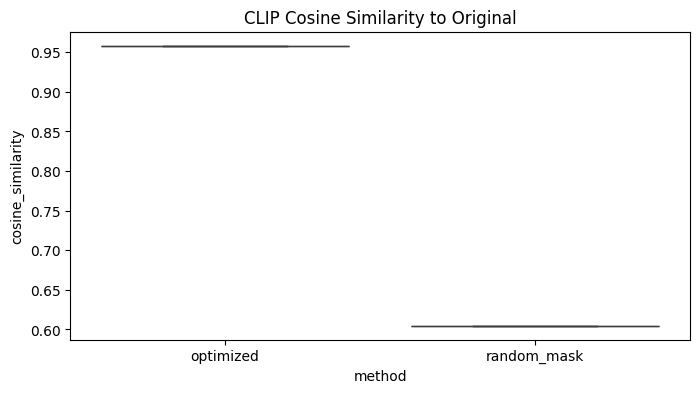

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt

df_masked["method"] = "random_mask"
df_embed["method"] = "optimized"
df_compare = pd.concat([df_embed, df_masked])

plt.figure(figsize=(8, 4))
sns.boxplot(data=df_compare, x="method", y="cosine_similarity")
plt.title("CLIP Cosine Similarity to Original")
plt.show()


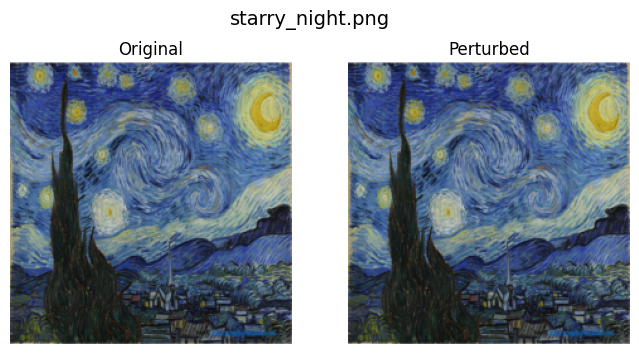

In [39]:
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image

def show_side_by_side(orig_tensor, perturbed_tensor, title=""):
    plt.figure(figsize=(8, 4))

    plt.subplot(1, 2, 1)
    plt.imshow(to_pil_image(torch.clamp(orig_tensor.squeeze(), 0, 1).cpu()))
    plt.title("Original")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(to_pil_image(torch.clamp(perturbed_tensor.squeeze(), 0, 1).cpu()))
    plt.title("Perturbed")
    plt.axis("off")

    if title:
        plt.suptitle(title, fontsize=14)

    plt.show()
show_side_by_side(img_tensors[0], cloaked_imgs[0], title=filenames[0])


visualize the differences

In [14]:
from transformers import BlipProcessor, BlipForConditionalGeneration

blip_processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
blip_model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base").to(device)

def caption_image(pil_img):
    inputs = blip_processor(images=pil_img, return_tensors="pt").to(device)
    out = blip_model.generate(**inputs, max_new_tokens=30)
    return blip_processor.decode(out[0], skip_special_tokens=True)

import pandas as pd

captions = []

for i, fname in enumerate(filenames):
    orig_pil = pil_imgs[i]
    cloaked_pil = to_pil_image(cloaked_imgs[i].squeeze())

    orig_caption = caption_image(orig_pil)
    cloaked_caption = caption_image(cloaked_pil)

    captions.append({
        "filename": fname,
        "original_caption": orig_caption,
        "cloaked_caption": cloaked_caption
    })

df_captions = pd.DataFrame(captions)
df_captions.to_csv("results/style_captions.csv", index=False)
df_captions

,filename,original_caption,cloaked_caption
0,starry_night.png,the starr by vincent van gogh,the starr by vincent van gogh


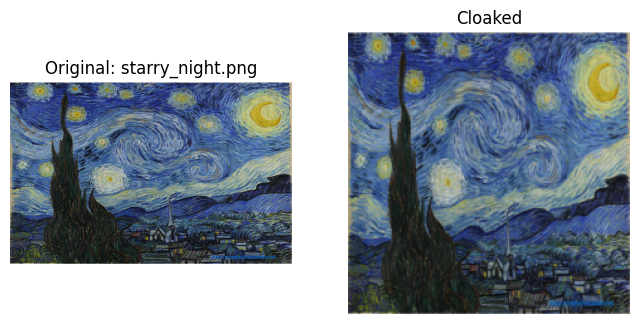

In [15]:
import matplotlib.pyplot as plt

for i in range(len(filenames)):
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(pil_imgs[i])
    plt.title(f"Original: {filenames[i]}")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(to_pil_image(cloaked_imgs[i].squeeze()))
    plt.title("Cloaked")
    plt.axis("off")

    plt.show()


testing how well style models can use the perturbed / original image

In [16]:
from diffusers import StableDiffusionPipeline
from transformers import BlipProcessor, BlipForConditionalGeneration
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

# Load BLIP
blip_processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
blip_model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base").to(device)

# Load SD
pipe = StableDiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4", torch_dtype=torch.float16).to(device)

def get_caption(img):
    inputs = blip_processor(images=img, return_tensors="pt").to(device)
    out = blip_model.generate(**inputs)
    return blip_processor.decode(out[0], skip_special_tokens=True)


model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

scheduler_config-checkpoint.json:   0%|          | 0.00/209 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/313 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

config.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

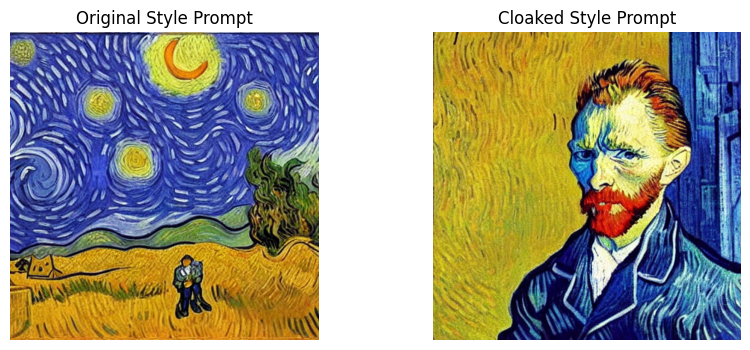

In [17]:
import matplotlib.pyplot as plt

for i, fname in enumerate(filenames):
    original_caption = get_caption(pil_imgs[i])
    cloaked_caption = get_caption(to_pil_image(cloaked_imgs[i].squeeze()))

    prompt_orig = f"A painting in the style of: {original_caption}"
    prompt_cloaked = f"A painting in the style of: {cloaked_caption}"

    img_orig = pipe(prompt_orig).images[0]
    img_cloaked = pipe(prompt_cloaked).images[0]

    # Compare side-by-side
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(img_orig)
    plt.title("Original Style Prompt")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(img_cloaked)
    plt.title("Cloaked Style Prompt")
    plt.axis("off")
    plt.show()


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


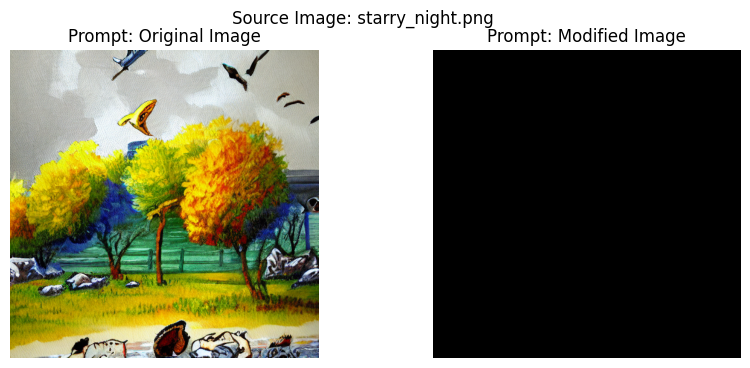

In [18]:
import matplotlib.pyplot as plt

for i, fname in enumerate(filenames):
    # Use fixed captions
    original_caption = "Original Image"
    cloaked_caption = "Modified Image"

    # Create prompts using fixed labels
    prompt_orig = f"A painting in the style of: {original_caption}"
    prompt_cloaked = f"A painting in the style of: {cloaked_caption}"

    # Generate using Stable Diffusion
    img_orig = pipe(prompt_orig).images[0]
    img_cloaked = pipe(prompt_cloaked).images[0]

    # Display results
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(img_orig)
    plt.title("Prompt: Original Image")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(img_cloaked)
    plt.title("Prompt: Modified Image")
    plt.axis("off")

    plt.suptitle(f"Source Image: {fname}", fontsize=12)
    plt.show()


compare embeddings

In [19]:
def get_clip_embedding(pil_image):
    inputs = clip_processor(images=pil_image, return_tensors="pt").to(device)
    with torch.no_grad():
        embedding = clip_model.get_image_features(**inputs)
        embedding = embedding / embedding.norm(dim=-1, keepdim=True)  # Normalize
    return embedding.squeeze()

In [20]:
from torchvision.transforms.functional import to_pil_image
import torch.nn.functional as F

embedding_diffs = []

for i in range(len(filenames)):
    orig_pil = pil_imgs[i]
    cloaked_pil = to_pil_image(torch.clamp(cloaked_imgs[i].squeeze(), 0, 1))

    # Get embeddings
    emb_orig = get_clip_embedding(orig_pil)
    emb_cloaked = get_clip_embedding(cloaked_pil)

    # Compute cosine similarity and Euclidean distance
    cosine_sim = F.cosine_similarity(emb_orig, emb_cloaked, dim=0).item()
    l2_dist = torch.norm(emb_orig - emb_cloaked).item()

    embedding_diffs.append({
        "filename": filenames[i],
        "cosine_similarity": cosine_sim,
        "l2_distance": l2_dist
    })


In [21]:
import pandas as pd

df_embed = pd.DataFrame(embedding_diffs)
df_embed.sort_values(by="cosine_similarity")  # or by "l2_distance"

,filename,cosine_similarity,l2_distance
0,starry_night.png,0.958163,0.289265


Next attempt

In [2]:
!pip install -q \
    diffusers==0.27.2 \
    transformers \
    accelerate \
    lpips         # <- perceptual‑loss library

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 68.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 107.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 86.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 40.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 824.8 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 102.3 MB/s eta 0:00:00


In [2]:
import torch, random, os
import torch.nn.functional as F
from torchvision import transforms
from torchvision.transforms.functional import to_pil_image
from PIL import Image
from transformers import CLIPTokenizer, CLIPImageProcessor, CLIPModel
import lpips                                   # ← now found!

device  = "cuda" if torch.cuda.is_available() else "cpu"
clip      = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
img_proc  = CLIPImageProcessor.from_pretrained("openai/clip-vit-base-patch32")
tok       = CLIPTokenizer.from_pretrained("openai/clip-vit-base-patch32")

lpips_fn  = lpips.LPIPS(net="alex").to(device)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /usr/local/lib/python3.11/dist-packages/lpips/weights/v0.1/alex.pth


style prompts

In [14]:
STYLE_PROMPTS = [
    'futuristic vaporwave poster'
    # "cubist illustration", "watercolor splash art", "digital pixel art",
    # "futuristic vaporwave poster", "mid‑century modern print",
    # "noir graphic novel panel", "abstract expressionist canvas",
    # "low‑poly 3D render", "ink wash painting", "minimalist geometric art",
    # add 50‑100 more eclectic, non‑copyrightable styles …
]

Get CLIP text embedding

In [4]:
@torch.no_grad()
@torch.no_grad()
def clip_text_embed(text: str):
    tokens = tok([text], return_tensors="pt").to(device)
    e = clip.get_text_features(**tokens)
    return F.normalize(e, dim=-1)

@torch.no_grad()
def clip_image_embed(pil_img):
    batch = img_proc(images=pil_img, return_tensors="pt").to(device)
    e = clip.get_image_features(**batch)
    return F.normalize(e, dim=-1)

In [5]:
TEXT_EMB_CACHE = {p: clip_text_embed(p) for p in STYLE_PROMPTS}

perturbation of images

In [21]:
def cloak_image_guided(img_tensor,
                       n_steps=250,
                       step_lr=1e-1,
                       alpha=1.0,
                       beta=1.0,
                       gamma=0.5):

    tgt_prompt = random.choice(STYLE_PROMPTS)
    text_emb   = TEXT_EMB_CACHE[tgt_prompt]           # [1,512]

    delta = torch.zeros_like(img_tensor, requires_grad=True)
    opt   = torch.optim.Adam([delta], lr=step_lr)

    with torch.no_grad():
        orig_emb = clip.get_image_features(
            **img_proc(images=to_pil_image(img_tensor.squeeze().cpu()),
                       return_tensors="pt").to(device)
        )
        orig_emb = F.normalize(orig_emb, dim=-1)

    for _ in range(n_steps):
        opt.zero_grad()

        pert = torch.clamp(img_tensor + delta, 0, 1)

        # -------------- use img_proc here -----------------
        out = clip.get_image_features(
            **img_proc(images=to_pil_image(pert.squeeze().cpu()),
                       return_tensors="pt").to(device)
        )
        pert_emb = F.normalize(out, dim=-1)

        # loss_away   =  F.cosine_similarity(orig_emb, pert_emb).mean()
        # loss_toward = -F.cosine_similarity(text_emb, pert_emb).mean()
        # loss_lpips  = lpips_fn(img_tensor, pert).mean()

        # loss = alpha*loss_away + beta*loss_toward + gamma*loss_lpips

        loss_away   = -F.cosine_similarity(orig_emb, pert_emb).mean()
        loss_toward = -F.cosine_similarity(text_emb, pert_emb).mean()
        loss_lpips  = lpips_fn(img_tensor, pert).mean()
        loss = alpha * loss_away + beta * loss_toward + gamma * loss_lpips

        loss.backward();  opt.step()
        delta.data.clamp_(-0.5, 0.5)

    return torch.clamp(img_tensor + delta.detach(), 0, 1), tgt_prompt


load in images

In [7]:
from PIL import Image
from torchvision import transforms
import torch

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

def load_images_from_folder(folder_path):
    image_tensors, image_pils, filenames = [], [], []

    for filename in sorted(os.listdir(folder_path)):
        if filename.lower().endswith((".png", ".jpg", ".jpeg")):
            path = os.path.join(folder_path, filename)
            pil_img = Image.open(path).convert("RGB")
            image_tensor = transform(pil_img).unsqueeze(0)
            image_tensors.append(image_tensor)
            image_pils.append(pil_img)
            filenames.append(filename)

    return image_pils, torch.cat(image_tensors), filenames

In [8]:
# Make sure 'data/' still contains your artwork files
# the 4 catlett pictures were taken from: https://www.nga.gov/exhibitions/2025/elizabeth-catlett-black-revolutionary-artist.html

pil_imgs, img_tensors, filenames = load_images_from_folder("data")
print(f"Loaded {len(filenames)} images.")

Loaded 3 images.


batch cloak and save

In [22]:
os.makedirs("results/guided_cloaked", exist_ok=True)
os.makedirs("results/guided_original", exist_ok=True)


cloaked_tensors, prompt_log = [], []

for i, fname in enumerate(filenames):
    img = img_tensors[i:i+1].to(device)
    cloaked, prompt = cloak_image_guided(img)

    # Save
    to_pil_image(img.squeeze().cpu()).save(f"results/guided_original/{fname}")
    to_pil_image(cloaked.squeeze().cpu()).save(f"results/guided_cloaked/{prompt}-{fname}")

    cloaked_tensors.append(cloaked.cpu())
    prompt_log.append({"file": fname, "prompt": prompt})

import pandas as pd
pd.DataFrame(prompt_log).to_csv("results/cloak_prompts.csv", index=False)


visual comparison

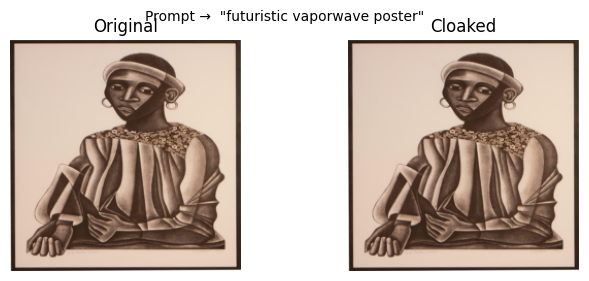

In [23]:
from matplotlib import pyplot as plt
show_idx = 0
plt.figure(figsize=(8,3))
plt.subplot(1,2,1); plt.imshow(to_pil_image(img_tensors[show_idx].squeeze())); plt.title("Original"); plt.axis("off")
plt.subplot(1,2,2); plt.imshow(to_pil_image(cloaked_tensors[show_idx].squeeze())); plt.title("Cloaked"); plt.axis("off")
plt.suptitle(f'Prompt →  "{prompt_log[show_idx]["prompt"]}"', fontsize=10)
plt.show()


Compare similarity

In [25]:
CLIP_MEAN = torch.tensor([0.4815, 0.4578, 0.4082], device=device).view(1, 3, 1, 1)
CLIP_STD  = torch.tensor([0.2686, 0.2613, 0.2758], device=device).view(1, 3, 1, 1)

def normalize_for_clip(img_tensor):
    return (img_tensor - CLIP_MEAN) / CLIP_STD


def get_clip_embedding(img_tensor):
    with torch.no_grad():
        normed = normalize_for_clip(img_tensor.to(device))
        return F.normalize(clip.get_image_features(normed), dim=-1)
orig_img   = img_tensors[0:1]      # original image (tensor)
cloaked_img = cloaked_tensors[0]   # if already detached and CPU, do .unsqueeze(0)

# Ensure cloaked is same shape + device
cloaked_img = cloaked_img.unsqueeze(0).to(device)

orig_emb   = get_clip_embedding(orig_img)
cloaked_emb = get_clip_embedding(cloaked_img)

clip_similarity = F.cosine_similarity(orig_emb, cloaked_emb).item()
clip_distance = 1 - clip_similarity

print(f"CLIP Similarity: {clip_similarity:.4f}")
print(f"CLIP Distance   : {clip_distance:.4f}")


ValueError: too many values to unpack (expected 4)

Comparing style models trained on original vs. perturbed images

In [5]:
!pip install -q --upgrade diffusers==0.27.2 "huggingface_hub==0.22.2"
!pip install -q --upgrade diffusers==0.27.2 peft bitsandbytes accelerate transformers ftfy

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
peft 0.15.2 requires huggingface_hub>=0.25.0, but you have huggingface-hub 0.22.2 which is incompatible.
transformers 4.51.3 requires huggingface-hub<1.0,>=0.30.0, but you have huggingface-hub 0.22.2 which is incompatible.


In [11]:
import huggingface_hub as hub
# add the missing alias if it doesn't exist
if not hasattr(hub, "cached_download"):
    def cached_download(*args, **kwargs):
        return hub.hf_hub_download(*args, **kwargs)
    hub.cached_download = cached_download

from diffusers import StableDiffusionPipeline, AutoencoderKL   # now works


In [12]:
from peft import LoraConfig, get_peft_model
import torch, random, os, shutil
from PIL import Image
import matplotlib.pyplot as plt

In [13]:
# assumes you still have `pil_imgs`, `cloaked_tensors`, `filenames`
orig_dir   = "lora_data/orig"
cloak_dir  = "lora_data/cloak"
os.makedirs(orig_dir,  exist_ok=True)
os.makedirs(cloak_dir, exist_ok=True)

for i,f in enumerate(filenames):
    pil_imgs[i].save(   f"{orig_dir}/{f}")
    to_pil_image(cloaked_tensors[i].squeeze()).save(f"{cloak_dir}/{f}")


fine turne Lora

In [14]:
def train_lora(data_dir, out_dir,
               prompt_token="<style>",
               lr=1e-4,
               steps=300):
    pipe = StableDiffusionPipeline.from_pretrained(
        "runwayml/stable-diffusion-v1-5",
        torch_dtype=torch.float16,
        safety_checker=None
    ).to(device)

    pipe.unet.requires_grad_(False)
    lora_cfg = LoraConfig(r=8, lora_alpha=16,
                          target_modules=["to_q", "to_k", "to_v", "to_out.0"])
    pipe.unet = get_peft_model(pipe.unet, lora_cfg)

    imgs  = [Image.open(f"{data_dir}/{f}").convert("RGB") for f in os.listdir(data_dir)]
    optim = torch.optim.Adam(pipe.unet.parameters(), lr=lr)

    for _ in tqdm(range(steps)):
        img = random.choice(imgs)

        pixel_values = (                      # shape 1×3×H×W  already batched
            pipe.image_processor.preprocess(img)
            .to(device, dtype=torch.float16)  # cast, move to GPU
        )

        latents = pipe.vae.encode(pixel_values).latent_dist.sample() * 0.18215

        noise      = torch.randn_like(latents)
        t          = torch.randint(0, pipe.scheduler.config.num_train_timesteps, (1,), device=device)
        noisy_lat  = pipe.scheduler.add_noise(latents, noise, t)

        with torch.no_grad():
            ids   = pipe.tokenizer([prompt_token], return_tensors="pt").input_ids.to(device)
            p_emb = pipe.text_encoder(ids)[0]

        pred  = pipe.unet(noisy_lat, t, encoder_hidden_states=p_emb).sample
        loss  = (pred - noise).pow(2).mean()
        loss.backward(); optim.step(); optim.zero_grad()

    pipe.save_pretrained(out_dir)
    return out_dir


train adapaters

In [15]:
from tqdm.auto import tqdm

In [16]:
orig_lora_path  = train_lora(orig_dir,  "lora_out/orig",  prompt_token="<orig>",  steps=300)
cloak_lora_path = train_lora(cloak_dir, "lora_out/cloak", prompt_token="<cloak>", steps=300)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


  0%|          | 0/300 [00:00<?, ?it/s]

OutOfMemoryError: CUDA out of memory. Tried to allocate 142.00 MiB. GPU 0 has a total capacity of 14.74 GiB of which 18.12 MiB is free. Process 136014 has 14.72 GiB memory in use. Of the allocated memory 14.52 GiB is allocated by PyTorch, and 61.98 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

load both adapters for inference

In [ ]:
base_pipe = StableDiffusionPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    torch_dtype=torch.float16,
    safety_checker=None
).to(device)

pipe_orig  = StableDiffusionPipeline.from_pretrained(orig_lora_path , torch_dtype=torch.float16).to(device)
pipe_cloak = StableDiffusionPipeline.from_pretrained(cloak_lora_path, torch_dtype=torch.float16).to(device)


generate and compare

In [ ]:
from transformers import CLIPImageProcessor, CLIPModel
clip_eval = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
img_proc  = CLIPImageProcessor.from_pretrained("openai/clip-vit-base-patch32")

def clip_sim(a, b):
    with torch.no_grad():
        ea = clip_eval.get_image_features(**img_proc(images=a, return_tensors="pt").to(device))
        eb = clip_eval.get_image_features(**img_proc(images=b, return_tensors="pt").to(device))
    return torch.cosine_similarity(ea, eb).item()

prompt_core = "A family of adults and children sitting around a table"
prompt_orig  = f"{prompt_core}, {pipe_orig.tokenizer.decode(pipe_orig.tokenizer('<orig>').input_ids[0])}"
prompt_cloak = f"{prompt_core}, {pipe_cloak.tokenizer.decode(pipe_cloak.tokenizer('<cloak>').input_ids[0])}"

gen_orig  = pipe_orig (prompt_orig,  num_inference_steps=30).images[0]
gen_cloak = pipe_cloak(prompt_cloak, num_inference_steps=30).images[0]

plt.figure(figsize=(10,4))
plt.subplot(1,2,1); plt.imshow(gen_orig ); plt.title("Trained on ORIGINAL"); plt.axis("off")
plt.subplot(1,2,2); plt.imshow(gen_cloak); plt.title("Trained on CLOAKED");  plt.axis("off")
plt.show()

print("CLIP similarity to one seed original art sample:")
print(" → adapter ORIG :", clip_sim(gen_orig , pil_imgs[0]))
print(" → adapter CLOAK:", clip_sim(gen_cloak, pil_imgs[0]))


attempt 2

In [2]:
import huggingface_hub as hub
# add the missing alias if it doesn't exist
if not hasattr(hub, "cached_download"):
    def cached_download(*args, **kwargs):
        return hub.hf_hub_download(*args, **kwargs)
    hub.cached_download = cached_download

from diffusers import StableDiffusionPipeline   # now works
from peft import LoraConfig, get_peft_model
from tqdm.auto import tqdm
from PIL import Image
import torch, os, random
from torchvision import transforms

In [10]:
def train_lora(data_dir, out_dir,
               prompt_token="<style>",
               steps=150,            # keep light
               lr=1e-4):

    # --- load base SD‑1.5 in FP16, but off‑load to CPU/gpu layer‑wise
    pipe = StableDiffusionPipeline.from_pretrained(
        "runwayml/stable-diffusion-v1-5",
        torch_dtype=torch.float16,
        safety_checker=None
    )
    pipe.enable_model_cpu_offload()

    # --- attach LoRA to the UNet
    lora_cfg = LoraConfig(
        r=8, lora_alpha=16,
        target_modules=["to_q", "to_k", "to_v", "to_out.0"]
    )
    pipe.unet = get_peft_model(pipe.unet, lora_cfg)
    opt = torch.optim.Adam(pipe.unet.parameters(), lr=lr)

    # --- prepare dataset (resize → 512 once)
    pre = transforms.Compose([transforms.Resize(512), transforms.CenterCrop(512)])
    imgs = [pre(Image.open(os.path.join(data_dir,f)).convert("RGB"))
            for f in os.listdir(data_dir) if f.lower().endswith(("png","jpg","jpeg"))]

    device = pipe.device  # points to GPU when a layer is off‑loaded in

    for _ in tqdm(range(steps)):
        img = random.choice(imgs)

        # preprocess → tensor (1×3×H×W, FP16, on GPU)
        pixel = pipe.image_processor.preprocess(img).to(device, dtype=torch.float16)

        # encode latents (VAE moved onto GPU only for its forward pass)
        lat   = pipe.vae.encode(pixel).latent_dist.sample() * 0.18215

        # diffusion noise step
        noise = torch.randn_like(lat)
        t     = torch.randint(0, pipe.scheduler.config.num_train_timesteps, (1,), device=device)
        noised= pipe.scheduler.add_noise(lat, noise, t)

        # frozen text encoder → prompt embedding
        with torch.no_grad():
            ids  = pipe.tokenizer([prompt_token], return_tensors="pt").input_ids.to(device)
            pemb = pipe.text_encoder(ids)[0]

        pred  = pipe.unet(noised, t, encoder_hidden_states=pemb).sample
        loss  = (pred - noise).pow(2).mean()

        loss.backward();  opt.step();  opt.zero_grad()
        torch.cuda.empty_cache()           # keep fragmentation low

    pipe.save_pretrained(out_dir)
    return out_dir


In [14]:
!pip uninstall -y bitsandbytes triton


Found existing installation: bitsandbytes 0.45.5
Uninstalling bitsandbytes-0.45.5:
  Successfully uninstalled bitsandbytes-0.45.5
Found existing installation: triton 2.2.0
Uninstalling triton-2.2.0:
  Successfully uninstalled triton-2.2.0


In [15]:
device = "cuda" if torch.cuda.is_available() else "cpu"

orig_lora_path  = train_lora("lora_data/orig",  "lora_out/orig",  prompt_token="<orig>")
cloak_lora_path = train_lora("lora_data/cloak", "lora_out/cloak", prompt_token="<cloak>")


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


ModuleNotFoundError: No module named 'bitsandbytes'

In [ ]:
from diffusers import StableDiffusionPipeline

base = StableDiffusionPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    torch_dtype=torch.float16,
    safety_checker=None
).to(device).enable_xformers_memory_efficient_attention()

pipe_orig  = StableDiffusionPipeline.from_pretrained(orig_lora_path , torch_dtype=torch.float16).to(device)
pipe_cloak = StableDiffusionPipeline.from_pretrained(cloak_lora_path, torch_dtype=torch.float16).to(device)

prompt_core   = "A majestic castle on top of a cliff under stormy skies"
img_orig  = pipe_orig (f"{prompt_core}, <orig>",  num_inference_steps=30).images[0]
img_cloak = pipe_cloak(f"{prompt_core}, <cloak>", num_inference_steps=30).images[0]

import matplotlib.pyplot as plt
plt.figure(figsize=(10,4))
plt.subplot(1,2,1); plt.imshow(img_orig ); plt.title("Adapter ORIG");  plt.axis("off")
plt.subplot(1,2,2); plt.imshow(img_cloak); plt.title("Adapter CLOAK"); plt.axis("off")
plt.show()
